# GPU bug report

## Import requirements

In [1]:
import os                                                                                                                                                                                                                                              
import traceback                                                                                                                                                                                                                                       
import random                                                                                                                                                                                                                                          
import pickle                                                                                                                                                                                                                                          
import configparser                                                                                                                                                                                                                                    
import torch                                                                                                                                                                                                                                           
import plotly.graph_objects as go                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                       
import gcnu_common.utils.config_dict                                                                                                                                                                                                                   
import svGPFA.stats.svGPFAModelFactory                                                                                                                                                                                                                 
import svGPFA.stats.svEM                                                                                                                                                                                                                               
import svGPFA.utils.configUtils                                                                                                                                                                                                                        
import svGPFA.utils.miscUtils                                                                                                                                                                                                                          
import svGPFA.utils.initUtils

## Configuration parameters

In [3]:
sim_res_number = 91450833
est_init_number = 551
n_repeats = 1
cuda_device_index = 0
est_init_config_filename_pattern = "../data/{:08d}_estimation_metaData.ini"
sim_res_config_filename_pattern = "../results/{:08d}_simulation_metaData.ini"

# Load data

In [4]:
sim_res_config_filename = sim_res_config_filename_pattern.format(                                                                                                                                                                                      
    sim_res_number)                                                                                                                                                                                                                                    
sim_res_config = configparser.ConfigParser()                                                                                                                                                                                                           
sim_res_config.read(sim_res_config_filename)                                                                                                                                                                                                           
sim_res_filename = sim_res_config["simulation_results"]["sim_res_filename"]                                                                                                                                                                            
with open(sim_res_filename, "rb") as f:                                                                                                                                                                                                                
    sim_res = pickle.load(f)                                                                                                                                                                                                                           
spikes_times = sim_res["spikes_times"]                                                                                                                                                                                                                 
n_trials = len(spikes_times)                                                                                                                                                                                                                           
n_neurons = len(spikes_times[0])                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                       
spikes_times = [[spikes_times[r][n].tolist() for n in range(n_neurons)]                                                                                                                                                                                
                for r in range(n_trials)]                                                                                                                                                                                                              
                                                                                                                                                                                                                                                       
sim_init_config_filename = sim_res_config["simulation_params"]["sim_init_config_filename"]                                                                                                                                                             
sim_init_config = configparser.ConfigParser()                                                                                                                                                                                                          
sim_init_config.read(sim_init_config_filename)                                                                                                                                                                                                         
trials_start_times = [float(str) for str in sim_init_config["data_structure_params"]["trials_start_times"][1:-1].split(",")]                                                                                                                           
trials_end_times = [float(str) for str in sim_init_config["data_structure_params"]["trials_end_times"][1:-1].split(",")]                                                                                                                               
                                                                                                                                                                                                                                                       
est_init_config_filename = est_init_config_filename_pattern.format(                                                                                                                                                                                    
    est_init_number)                                                                                                                                                                                                                                   
est_init_config = configparser.ConfigParser()                                                                                                                                                                                                          
est_init_config.read(est_init_config_filename)                                                                                                                                                                                                         
n_latents = int(est_init_config["model_structure_params"]["n_latents"]) 

## Build parameters

### Build configuration file parameter specifications 

In [5]:
args_info = svGPFA.utils.initUtils.getArgsInfo()
strings_dict = gcnu_common.utils.config_dict.GetDict(                                                                                                                                                                                                  
    config=est_init_config).get_dict()                                                                                                                                                                                                                 
config_file_params = svGPFA.utils.initUtils.getParamsDictFromStringsDict(                                                                                                                                                                              
    n_latents=n_latents, n_trials=n_trials, strings_dict=strings_dict,                                                                                                                                                                                 
    args_info=args_info)

### Build default parameter specificiations

In [6]:
default_params = svGPFA.utils.initUtils.getDefaultParamsDict(                                                                                                                                                                                          
    n_neurons=n_neurons, n_trials=n_trials, n_latents=n_latents) 

## Perform estimations

In [8]:
devices = ["cpu", f"cuda:{cuda_device_index}"]                                                                                                                                                                                                         
elapsed_times = torch.empty((len(devices), n_repeats), dtype=torch.double)                                                                                                                                                                             
lower_bounds = torch.empty((len(devices), n_repeats), dtype=torch.double)                                                                                                                                                                              
num_fun_eval = torch.empty((len(devices), n_repeats), dtype=torch.double)                                                                                                                                                                              
num_iter = torch.empty((len(devices), n_repeats), dtype=torch.double)

for d, device in enumerate(devices):                                                                                                                                                                                                                   
    r = 0                                                                                                                                                                                                                                              
    while r < n_repeats:                                                                                                                                                                                                                               
        print(f"Processing device {device}, repeat {r}")                                                                                                                                                                                               
        #    finally, get the parameters from the dynamic,                                                                                                                                                                                             
        #    configuration file and default parameter specifications                                                                                                                                                                                   
        params, kernels_types = svGPFA.utils.initUtils.getParamsAndKernelsTypes(                                                                                                                                                                       
            n_trials=n_trials, n_neurons=n_neurons, n_latents=n_latents,                                                                                                                                                                               
            trials_start_times=trials_start_times,                                                                                                                                                                                                     
            trials_end_times=trials_end_times,                                                                                                                                                                                                         
            dynamic_params_spec={},                                                                                                                                                                                                        
            config_file_params_spec=config_file_params,                                                                                                                                                                                                
            default_params_spec=default_params)                                                                                                                                                                                                        
                                                                                                                                                                                                                                                       
        # build kernels                                                                                                                                                                                                                                
        kernels_params0 = params["initial_params"]["posterior_on_latents"]["kernels_matrices_store"]["kernels_params0"]                                                                                                                                
        kernels = svGPFA.utils.miscUtils.buildKernels(                                                                                                                                                                                                 
            kernels_types=kernels_types, kernels_params=kernels_params0)                                                                                                                                                                               
                                                                                                                                                                                                                                                       
        # create model                                                                                                                                                                                                                                 
        kernelMatrixInvMethod = svGPFA.stats.svGPFAModelFactory.kernelMatrixInvChol                                                                                                                                                                    
        indPointsCovRep = svGPFA.stats.svGPFAModelFactory.indPointsCovChol                                                                                                                                                                             
        model = svGPFA.stats.svGPFAModelFactory.SVGPFAModelFactory.buildModelPyTorch(                                                                                                                                                                  
            conditionalDist=svGPFA.stats.svGPFAModelFactory.PointProcess,                                                                                                                                                                              
            linkFunction=svGPFA.stats.svGPFAModelFactory.ExponentialLink,                                                                                                                                                                              
            embeddingType=svGPFA.stats.svGPFAModelFactory.LinearEmbedding,                                                                                                                                                                             
            kernels=kernels, kernelMatrixInvMethod=kernelMatrixInvMethod,                                                                                                                                                                              
            indPointsCovRep=indPointsCovRep)                                                                                                                                                                                                           
                                                                                                                                                                                                                                                       
        model.setParamsAndData(                                                                                                                                                                                                                        
            measurements=spikes_times,                                                                                                                                                                                                                 
            initial_params=params["initial_params"],                                                                                                                                                                                                   
            eLLCalculationParams=params["ell_calculation_params"],                                                                                                                                                                                     
            priorCovRegParam=params["optim_params"]["prior_cov_reg_param"])                                                                                                                                                                            
                                                                                                                                                                                                                                                       
        model.to(device=device)                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                       
        # maximize lower bound                                                                                                                                                                                                                         
        svEM = svGPFA.stats.svEM.SVEM_PyTorch()                                                                                                                                                                                                        
        try:                                                                                                                                                                                                                                           
            lowerBoundHist, elapsedTimeHist, terminationInfo,\
            iterationsModelParams, num_fun_eval[d, r], num_iter[d, r] = \
                svEM.maximizeSimultaneously(model=model,                                                                                                                                                                                               
                                            optim_params=params["optim_params"])                                                                                                                                                                       
            elapsed_times[d, r] = elapsedTimeHist[-1]                                                                                                                                                                                                  
            lower_bounds[d, r] = lowerBoundHist[-1]                                                                                                                                                                                                    
        except Exception as e:                                                                                                                                                                                                                         
            print("Exception detected. Retrying")                                                                                                                                                                                                      
            stack_trace = traceback.format_exc()                                                                                                                                                                                                       
            print(e)                                                                                                                                                                                                                                   
            print(stack_trace)                                                                                                                                                                                                                         
        print("Device {:s}, Repeat {:d}: elapsed time {:f}, "                                                                                                                                                                                          
              "elapsed time per function call {:f}, "                                                                                                                                                                                                  
              "lower bound {:f}".format(device, r, elapsed_times[d, r],                                                                                                                                                                                
                                        elapsed_times[d, r]/num_fun_eval[d, r],                                                                                                                                                                        
                                        lower_bounds[d, r]))                                                                                                                                                                                           
        r += 1                                                                                                                                                                                                                                         
 

Processing device cpu, repeat 0
Extracted config_file_params_spec[optim_params][n_quad]=200
Extracted config_file_params_spec[ind_points_locs_params0][n_ind_points]=tensor([9, 9], dtype=torch.int32)
Extracted from config_file c0_distribution=Normal, c0_loc=0.0, c0_scale=1.0, c0_random_seed=None
Extracted from config_file d0_distribution=Normal, d0_loc=0.0, d0_scale=1.0, d0_random_seed=None
Extracted from config_file k_type=exponentialQuadratic and k_lengthsales0=2.0
Extracted from config_file ind_points_locs0_layout=uniform
Extracted from config_file variational_mean0_constant_value=0.0
Extracted from config_file variational_cov0_diag_value=0.1
Extracted config_file_params_spec[optim_params][n_quad]=200
Extracted config_file_params_spec[optim_params][prior_cov_reg_param]=0.001
Extracted config_file_params_spec[optim_params][optim_method]=ECM
Extracted config_file_params_spec[optim_params][em_max_iter]=10
Extracted config_file_params_spec[optim_params][verbose]=True
Extracted config_fil

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=1, r=4
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.1525,  0.1785,  0.1184,  0.2201, -0.0110,  0.1297,  0.1686, -0.0620,
         1.0464])
tensor([-0.0463,  0.0734, -0.0053,  0.0491, -0.0344,  0.0394,  0.0760, -0.1648,
         1.0199])
tensor([-2.5669e-02, -7.1801e-02, -9.4012e-04,  3.2813e-02, -2.6826e-02,
         4.1851e-02,  8.4260e-02, -1.9566e-01,  1.0781e+00])
tensor([-0.0190, -0.0362, -0.0057,  0.0226, -0.0254,  0.0341,  0.0766, -0.2016,
         1.0858])
tensor([-0.0173, -0.0171,  0.0021,  0.0302, -0.0175,  0.0443,  0.0833, -0.1902,
         1.0905])
tensor([-0.0063, -0.0212,  0.0304,  0.0414, -0.0173,  0.0543,  0.0924, -0.1833,
         1.0756])
tensor([-0.0097, -0.0184,  0.0369,  0.0446, -0.0350,  0.0503,  0.0915, -0.2001,
         1.0788])
tensor([-6.8008e-03,  5.2871e-04,  4.0909e-02,  4.7144e-02, -3.7203e-02,
         4.9891e-02,  9.1813e-02, -2.0041e-01,  1.0785e+00])
tensor([-0.0054,  0.0585,  0.0551,  0.0554, -0.0406,  0.0531,  0.0973, -0.2071,
         1.1146])
tensor([-0.0202,  0.0645,  0.0629,  0.0598, -0

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=1, r=10
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([ 1.0007, -0.2551, -0.0492, -0.0318,  0.0323, -0.0374,  0.0917,  0.5265,
         0.9165])
tensor([ 1.0003, -0.2550, -0.0493, -0.0317,  0.0323, -0.0379,  0.0916,  0.5266,
         0.9163])
tensor([ 1.0008, -0.2552, -0.0494, -0.0316,  0.0324, -0.0385,  0.0915,  0.5264,
         0.9168])
tensor([ 1.0016, -0.2551, -0.0496, -0.0315,  0.0325, -0.0396,  0.0912,  0.5258,
         0.9178])
tensor([ 1.0032, -0.2552, -0.0497, -0.0316,  0.0326, -0.0406,  0.0908,  0.5248,
         0.9197])
tensor([ 1.0055, -0.2548, -0.0498, -0.0319,  0.0327, -0.0414,  0.0902,  0.5233,
         0.9224])
tensor([ 1.0056, -0.2542, -0.0498, -0.0321,  0.0326, -0.0407,  0.0900,  0.5231,
         0.9226])
tensor([ 1.0074, -0.2543, -0.0500, -0.0324,  0.0325, -0.0391,  0.0901,  0.5220,
         0.9245])
tensor([ 1.0084, -0.2538, -0.0503, -0.0323,  0.0325, -0.0381,  0.0902,  0.5213,
         0.9257])
tensor([-0.0699, -0.0297,  0.0298,  0.0376, -0.1158,  0.0816,  1.0016, -0.4536,
         0.9872])
tensor([ 1.0016,  0.

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=1, r=7
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.0751, -0.0334,  0.0284,  0.0373, -0.1172,  0.0837,  1.0072, -0.4540,
         0.9873])
tensor([ 1.0068,  0.2215,  0.0512, -0.0527,  0.0406, -0.0294, -0.0457,  0.1029,
        -0.3216])
tensor([ 1.0149, -0.2524, -0.0516, -0.0312,  0.0330, -0.0397,  0.0912,  0.5168,
         0.9334])
tensor([-0.0753, -0.0316,  0.0288,  0.0368, -0.1181,  0.0841,  1.0097, -0.4543,
         0.9873])
tensor([ 1.0093,  0.2223,  0.0505, -0.0525,  0.0405, -0.0302, -0.0434,  0.1029,
        -0.3207])
tensor([ 1.0170, -0.2531, -0.0515, -0.0319,  0.0331, -0.0415,  0.0916,  0.5154,
         0.9358])
tensor([-0.0762, -0.0299,  0.0294,  0.0366, -0.1186,  0.0843,  1.0105, -0.4545,
         0.9873])
tensor([ 1.0101,  0.2226,  0.0502, -0.0522,  0.0403, -0.0312, -0.0429,  0.1028,
        -0.3204])
tensor([ 1.0177, -0.2530, -0.0513, -0.0322,  0.0330, -0.0417,  0.0918,  0.5149,
         0.9365])
tensor([-0.0776, -0.0291,  0.0297,  0.0367, -0.1183,  0.0844,  1.0104, -0.4546,
         0.9874])
tensor([ 1.0099,  0.

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=11
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")
/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=1, r=1
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.8602, -0.0741, -0.1158,  0.1459,  0.0229,  0.1227,  0.4536, -0.7334,
         1.3493])
tensor([-0.3257, -0.2165, -0.2519, -0.5261, -0.2255,  0.1700, -0.2651, -0.4503,
         1.2194])
tensor([-4.6890e-01, -1.5644e-01, -3.2272e-02, -1.1897e-01, -1.6822e-03,
         1.7514e-01,  1.6599e-01, -6.7948e-01,  1.6977e+00])
tensor([-0.4127, -0.0390, -0.0432, -0.0752, -0.0302, -0.0356, -0.0260, -0.3517,
         1.1064])
tensor([-0.0530, -0.2070, -0.0752, -0.2811, -0.2677, -0.0116, -0.0502, -0.2856,
         1.0035])
tensor([-0.1313,  0.2917, -0.0224, -0.0461, -0.0588, -0.0421, -0.0192, -0.3390,
         1.4966])
tensor([-0.2907, -0.0349,  0.0479, -0.0717, -0.0344, -0.0456, -0.0379, -0.2523,
         1.0423])
tensor([-0.0924,  0.2055, -0.0269, -0.9121, -0.0859, -0.0524, -0.0472, -0.2402,
         1.4039])
tensor([-0.0881,  0.1793, -0.0243, -0.9300, -0.0665, -0.0211, -0.0194, -0.2219,
         1.1319])
tensor([-0.0842,  0.1695, -0.0242, -0.9421, -0.0676, -0.0217, -0.0194, -0.2149,
  

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=0
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")
/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=9
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")
/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=1, r=14
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.2378, -0.0865, -0.1074, -0.0510, -0.1041, -0.1372,  0.1461, -0.2950,
         1.1079])
tensor([ 0.0156,  1.0113, -0.2261, -0.2239,  0.2375,  0.1257, -0.0734, -0.1565,
         1.6619])
tensor([-0.4116, -0.0777, -0.0370, -0.0383, -0.1084, -0.1063,  0.1413, -0.3060,
         1.7782])
tensor([-0.1429,  0.0958, -0.1070, -0.1218, -0.1235,  0.1730,  0.0112, -0.1546,
         1.6320])
tensor([-0.1275,  0.3898, -0.1202,  0.0329, -0.0380, -0.0664, -0.1108, -0.3140,
         2.3253])
tensor([-0.1130, -0.0528, -0.0218, -0.0869, -0.0587, -0.0484, -0.1267, -0.2849,
         1.0833])
tensor([ 0.0240,  0.6068, -0.0876, -0.0892,  0.0905,  0.0521, -0.0320, -0.1169,
         1.0415])
tensor([-0.3186, -0.0480,  0.0233, -0.0366, -0.0572, -0.0558,  0.0563, -0.2606,
         1.1767])
tensor([-0.0572, -0.0301, -0.0809, -0.1577, -0.1374,  0.0792,  0.0127, -0.1724,
         1.0752])
tensor([-0.1024,  0.2534, -0.0601, -0.5839, -0.0573, -0.0386, -0.0532, -0.2552,
         1.5544])
tensor([ 0.0290,  0.

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=3
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.3267, -0.0845, -0.0636, -0.0718, -0.0638, -0.0440,  0.2189, -0.4663,
         1.4290])
tensor([ 0.1681, -0.1518, -0.1034, -0.0692, -0.1855, -0.0574, -0.1482, -0.4499,
         1.0297])
tensor([ 0.0927,  1.2840, -0.2163, -0.2970,  0.3039,  0.0928, -0.1371, -0.2637,
         2.1782])
tensor([-0.4964, -0.1000,  0.1969, -0.0370, -0.0820, -0.0735,  0.1216, -0.4808,
         2.4341])
tensor([-0.3687, -0.0426, -0.1412, -0.2459, -0.2688,  0.2680,  0.0699, -0.1862,
         2.2295])
tensor([-0.2183,  0.5409, -0.1200,  0.6514, -0.0939, -0.0595, -0.0655, -0.5048,
         3.2016])
tensor([-0.1535, -0.1311, -0.0723, -0.1567, -0.1396, -0.0606, -0.1643, -0.4864,
         1.4457])
tensor([-0.3373, -0.0875, -0.0474, -0.0760, -0.0576, -0.0296,  0.2284, -0.4910,
         1.4753])
tensor([ 0.1751, -0.1612, -0.1051, -0.0605, -0.1983, -0.0512, -0.1584, -0.4676,
         1.0687])
tensor([ 0.0957,  1.3255, -0.2145, -0.3080,  0.2993,  0.0944, -0.1350, -0.2818,
         2.2480])
tensor([-0.5092, -0.

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=1, r=5
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.4598, -0.1466, -0.0078, -0.1318, -0.0564,  0.0662,  0.3208, -0.7395,
         2.0685])
tensor([ 0.2500, -0.2266, -0.1572, -0.0438, -0.3252, -0.0493, -0.2688, -0.6566,
         1.5226])
tensor([ 0.1288,  1.8563, -0.2645, -0.4692,  0.3446,  0.0994, -0.1877, -0.4597,
         3.1441])
tensor([-0.6657, -0.2113,  0.4834, -0.0308, -0.1102, -0.0674,  0.1006, -0.7423,
         3.5541])
tensor([-0.6882, -0.1135, -0.2287, -0.3748, -0.3940,  0.3219,  0.0409, -0.1919,
         3.2596])
tensor([-0.4008,  0.7786, -0.1937,  1.3269, -0.1578, -0.0580, -0.0421, -0.7956,
         4.6578])
tensor([ 0.0748,  1.0158,  0.5299, -0.1808,  0.0399, -0.0424, -0.1538, -0.0766,
        -1.5915])
tensor([-0.2867, -0.2016, -0.0971, -0.2657, -0.2374,  0.0469, -0.3026, -0.7522,
         2.1456])
tensor([-0.4492, -0.1415, -0.0085, -0.1268, -0.0557,  0.0589,  0.3165, -0.7196,
         2.0268])
tensor([ 0.2457, -0.2190, -0.1526, -0.0440, -0.3146, -0.0486, -0.2600, -0.6428,
         1.4910])
tensor([ 0.1277,  1.

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=6
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")


tensor([-0.5589, -0.2042, -0.0151, -0.1903, -0.0772,  0.1184,  0.3427, -0.9188,
         2.5118])
tensor([ 0.2842, -0.2795, -0.2080, -0.0567, -0.4134, -0.0664, -0.3558, -0.7798,
         1.8500])
tensor([ 0.1387,  2.2543, -0.3037, -0.5660,  0.3496,  0.0844, -0.2335, -0.5931,
         3.8185])
tensor([-0.7798, -0.2946,  0.6025, -0.0561, -0.1482, -0.0844,  0.0397, -0.9110,
         4.3171])
tensor([-0.8999, -0.1588, -0.2982, -0.4634, -0.4631,  0.3204,  0.0234, -0.2133,
         3.9610])
tensor([-0.5301,  0.9210, -0.2560,  1.4156, -0.2235, -0.0830, -0.0509, -0.9851,
         5.6585])
tensor([ 0.0603,  1.1817,  0.4916, -0.2441,  0.0342, -0.0566, -0.1988, -0.1115,
        -1.9658])
tensor([-0.3773, -0.2584, -0.1326, -0.3391, -0.3009,  0.0861, -0.4013, -0.9277,
         2.6155])
tensor([-0.5724, -0.2193, -0.0126, -0.2092, -0.0812,  0.1329,  0.3203, -0.9457,
         2.5469])
tensor([ 0.2717, -0.2971, -0.2175, -0.0557, -0.4272, -0.0658, -0.3763, -0.7840,
         1.8784])
tensor([ 0.1291,  2.

/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svLowerBound.py:53: UserWarning: infinity lower bound detected
  warnings.warn("infinity lower bound detected")
/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=2
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")
/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=4
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r}")
/nfs/ghome/live/rapela/dev/work/ucl/gatsby-swc/gatsby/svGPFA/repos/svGPFA/src/svGPFA/stats/svEM.py:437: UserWarning: posterior variance is larger than the prior variance: k=0, r=7
  warnings.warn(f"posterior variance is larger than the prior variance: k={k}, r={r

tensor([-51.2931, -29.4136,   2.5281, -35.5179,  -3.6183,  36.6741, -22.4477,
        -82.5044, 181.6537])
tensor([-15.7848,  31.2961, -44.2757, -49.3607,  35.6075, -11.6870, -73.2873,
        -10.9604, -33.8430])
tensor([ -2.5659, -41.7797, -21.2818,   1.5522, -33.8870,   0.8875, -45.2832,
        -33.6490, 136.9243])
tensor([  -0.3401,    8.2117,  -20.4431,   36.1226,  -23.4966,   -5.5983,
          -9.0797,  -54.9756, -175.5188])
tensor([-7.1184e+01, -1.7901e+01,  1.1001e+01, -2.9744e+01, -1.8900e+01,
        -7.5254e+00,  1.6164e-01, -2.4070e+01, -1.7848e+02])
tensor([ -25.0594,  -30.1112,   22.5198,    0.9451,  -26.0457,   -7.9408,
           8.7037,   45.4336, -130.0739])
tensor([ -16.1313,  -40.4242,   19.9130,  -73.9434,  -14.2239,  -13.4763,
          -2.1186,   90.1159, -153.9137])
tensor([ -9.4822, 167.1244,   3.8301, -20.3150, -54.9184, -17.6891,  -3.5659,
        -69.8369, 280.7403])
tensor([   0.4469,  -26.4753,    3.8738,   -3.1183,   -4.8264,   -5.4042,
          34.146

## Plot results

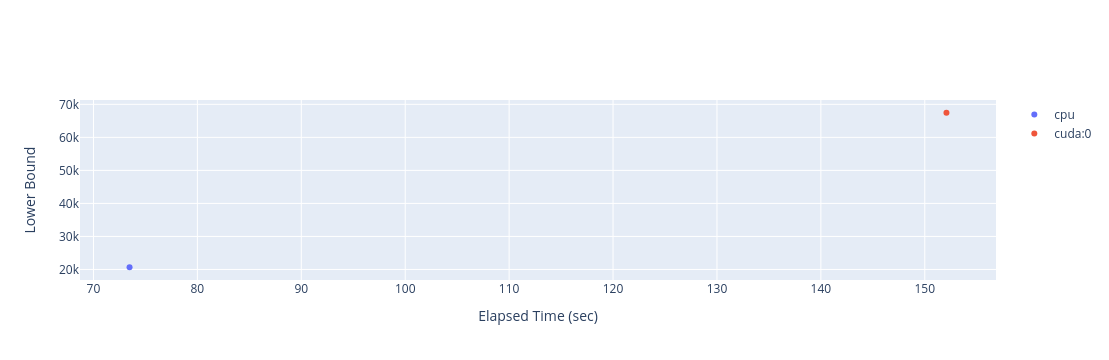

In [11]:
hoovertext = [[],[]]                                                                                                                                                                                                                                   
for d, device in enumerate(devices):                                                                                                                                                                                                                   
    for r in range(n_repeats):                                                                                                                                                                                                                         
        hoovertext[d].append(                                                                                                                                                                                                                          
            (f"elapsed time: {elapsed_times[d,r]}<br>"
             f"elapsed_time_per_funcall: "                                                                                                                                                                                                             
             f"{elapsed_times[d,r]/num_fun_eval[d,r]}<br>"
             f"lower bound: {lower_bounds[d,r]}<br>"
             f"num_fun_eval: {num_fun_eval[d,r]}<br>"                                                                                                                                                                                                  
             f"num_iter: {num_iter[d,r]}"                                                                                                                                                                                                          
            )  
        )                                                                                                                                                                                               
                                                                                                                                                                                                                                                       
fig = go.Figure()                                                                                                                                                                                                                                      
for d in range(len(devices)):                                                                                                                                                                                                                          
    trace = go.Scatter(x=elapsed_times[d,:], y=lower_bounds[d, :],                                                                                                                                                                                     
                       mode="markers", name=devices[d],                                                                                                                                                                                                
                       hovertext=hoovertext[d], hoverinfo="text")                                                                                                                                                                                      
    fig.add_trace(trace)                                                                                                                                                                                                                               
fig.update_layout(xaxis_title="Elapsed Time (sec)")                                                                                                                                                                                                    
fig.update_layout(yaxis_title="Lower Bound")                                                                                                                                                                                                           
                                                                                                                                                                                                                                                       
fig